# Diabetes Patients Early Readmissions Prediction

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Frantisek Sefcik](https://github.com/FrantisekSefcik)

## Model Selection

In this jupyter notebook, we will try multiple models for prediction and choose the best fitting one.

### Setup and import libraries

In [1]:
# Automatically reloading imported modules
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

# Supress libraries deprecation import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier


from src.preprocessing.helpers import describe_dataset
from src.evaluation import *

### Load train and test data

In [4]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [5]:
describe_dataset(X_train, X_test, y_train, y_test)

Number of train data: 81409
Number of test data: 20353
Number of features: 58
Classes:
	0 :
	    train: 72315 samples, 89.0%
	    test: 18090 samples, 89.0%

	1 :
	    train: 9094 samples, 11.0%
	    test: 2263 samples, 11.0%



### Data balancing

#### Undersampling with NearMiss

In [6]:
X_train_undersampled, y_train_undersampled = undersample(X_train, y_train)

In [8]:
len(X_train_undersampled), len(y_train_undersampled)

(18188, 18188)

#### Oversampling with SMOTE

In [9]:
X_train_oversampled, y_train_oversampled = oversample(X_train, y_train)

In [10]:
len(X_train_oversampled), len(y_train_oversampled)

(144630, 144630)

### Models training and evaluation

We will evaluate three models:
* Random forest
* MLP
* XGBoost

For complex evaluation of models we  print multiple metrics like accuracy, precision, recal, f1-score or AUC score. Also we plot confusion matrics and ROC curve to better understand model. To final evaluation will be choosen a model with highest AUC score, because AUC score could only tell us how model is good in predicting True Positive  and False Positive.

#### Random Forest

##### 1. Original data

              precision    recall  f1-score   support

           0       0.93      0.60      0.73     18090
           1       0.16      0.62      0.26      2263

    accuracy                           0.60     20353
   macro avg       0.54      0.61      0.49     20353
weighted avg       0.84      0.60      0.67     20353

ROC AUC score: 0.61


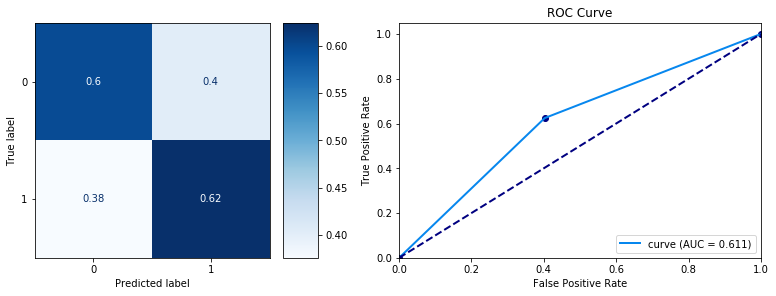

In [25]:
rf = RandomForestClassifier(max_depth=10, random_state=42, n_estimators=100
                             ,class_weight={0:1,1:9}, min_samples_split=5
                            )
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test)

##### 2. Undersampled data

              precision    recall  f1-score   support

           0       0.86      0.35      0.50     18090
           1       0.10      0.56      0.17      2263

    accuracy                           0.37     20353
   macro avg       0.48      0.46      0.33     20353
weighted avg       0.78      0.37      0.46     20353

ROC AUC score: 0.46


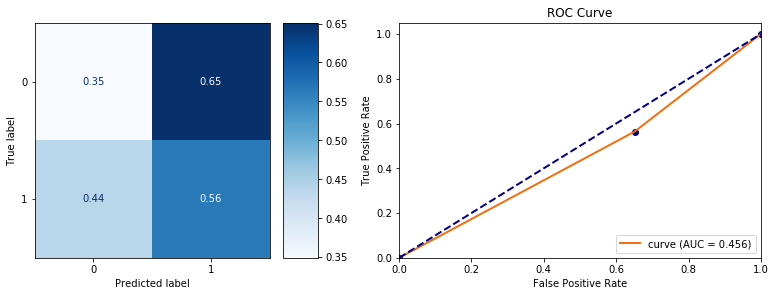

In [35]:
rf_u = RandomForestClassifier(max_depth=10, random_state=42, n_estimators=100, 
                             min_samples_leaf=2)
rf_u.fit(X_train_undersampled, y_train_undersampled)
evaluate_model(rf_u, X_test, y_test)

##### 3. Oversampled data

              precision    recall  f1-score   support

           0       0.92      0.45      0.60     18090
           1       0.13      0.68      0.22      2263

    accuracy                           0.47     20353
   macro avg       0.53      0.56      0.41     20353
weighted avg       0.83      0.47      0.56     20353

ROC AUC score: 0.56


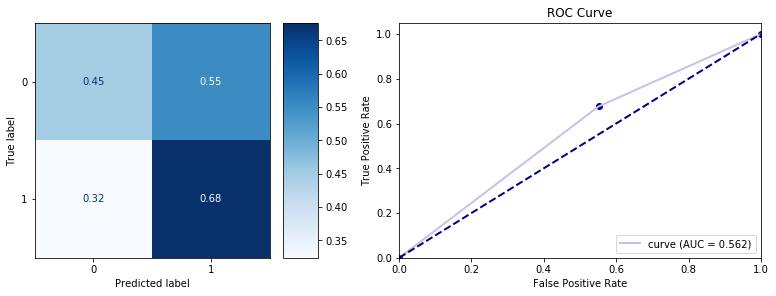

In [60]:
rf_o = RandomForestClassifier(max_depth=11, random_state=42, n_estimators=100, min_samples_leaf=2, 
                              class_weight={0:1,1:4})
rf_o.fit(X_train_oversampled, y_train_oversampled)
evaluate_model(rf_o, X_test, y_test)

##### Random forest conclusion

The comparision Random forest models on original, undersampled and oversampled data you can see in table bellow. We manually tuned hyperparameters to achieve the best performance for each model. The best AUC score achieved model without data balancing techniques, what can by a sign of chaotic feature space distribution. With SMOTE technique we had to use class weight parameter, where we push up minority class to obtain better results, what is next sign that SMOTE oversampling doesnt work properly on our data.

In [61]:
compare_models([rf, rf_u, rf_o], 
               ['RF', 'RF undersampled', 'RF oversampled'], 
               X_test, y_test)

                    Accuracy   F1 (micro)  F1 (macro)  Precission   Recall   AUC ROC
RF                |   0.60   |   0.60    |   0.49    |   0.16    |   0.62   |   0.61   |
RF undersampled   |   0.37   |   0.37    |   0.33    |   0.10    |   0.56   |   0.46   |
RF oversampled    |   0.47   |   0.47    |   0.41    |   0.13    |   0.68   |   0.56   |


##### Feature importances 

We take look on the most important features obtained by RF on original data. We can see that most useful features correspond with similar works from publicated papers. 

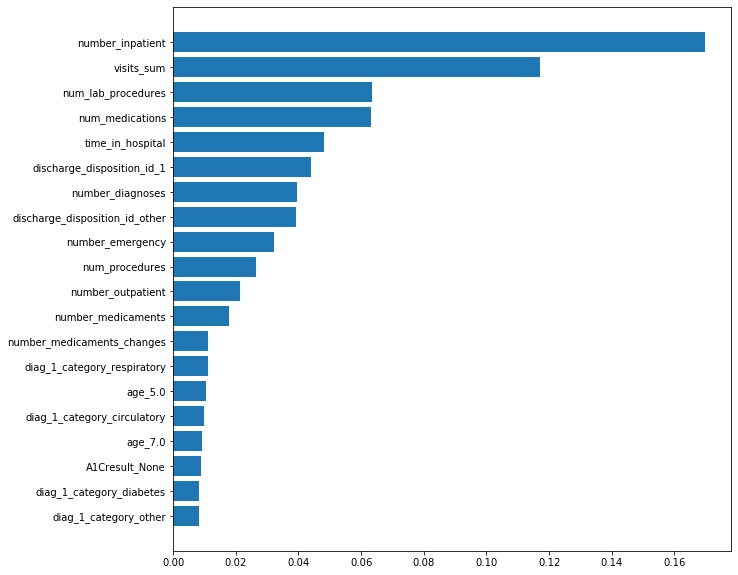

In [22]:
sorted_features = plot_feature_importance(rf.feature_importances_, X_train.columns, 20)

#### XGBoost

##### 1. Original data

              precision    recall  f1-score   support

           0       0.93      0.45      0.61     18090
           1       0.14      0.74      0.24      2263

    accuracy                           0.48     20353
   macro avg       0.54      0.60      0.43     20353
weighted avg       0.84      0.48      0.57     20353

ROC AUC score: 0.6


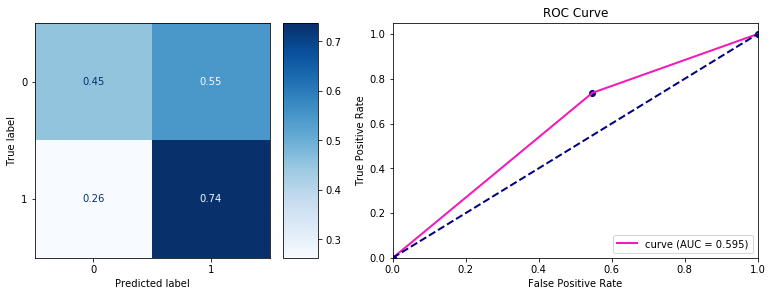

In [43]:
xg = xgb.XGBClassifier(random_state=42, learning_rate=0.001, max_depth=5, eta=0.1, scale_pos_weight=10)
xg.fit(X_train,y_train)
evaluate_model(xg, X_test, y_test)

##### 2. Undersampled data

              precision    recall  f1-score   support

           0       0.86      0.36      0.51     18090
           1       0.10      0.55      0.17      2263

    accuracy                           0.38     20353
   macro avg       0.48      0.46      0.34     20353
weighted avg       0.78      0.38      0.47     20353

ROC AUC score: 0.46


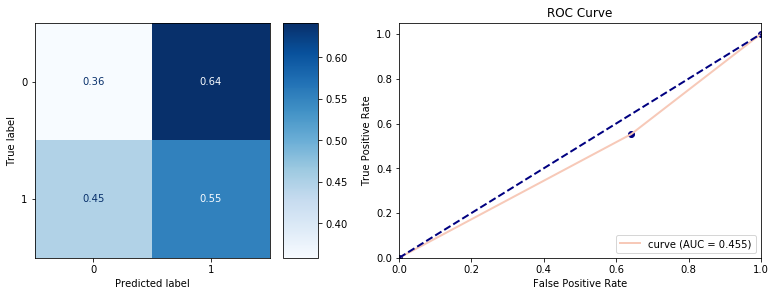

In [51]:
xg_u = xgb.XGBClassifier(random_state=42,learning_rate=0.01, max_depth=6)
xg_u.fit(X_train_undersampled, y_train_undersampled)
evaluate_model(xg_u, X_test, y_test)

##### 3. Oversampled data

              precision    recall  f1-score   support

           0       0.91      0.53      0.67     18090
           1       0.14      0.58      0.22      2263

    accuracy                           0.54     20353
   macro avg       0.52      0.56      0.45     20353
weighted avg       0.82      0.54      0.62     20353

ROC AUC score: 0.56


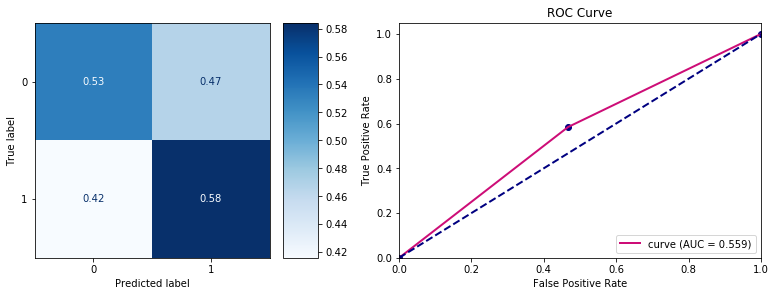

In [56]:
xg_o = xgb.XGBClassifier(random_state=42,learning_rate=0.001, scale_pos_weight=4)
xg_o.fit(X_train_oversampled, y_train_oversampled)
evaluate_model(xg_o, X_test, y_test)

##### XGBoost conclusion

With XGBoost models we achieved very similar results as with Random forest. The same patterns in data balancers are observed also here. Undersampling doesn't have good results and oversampling need class weight balancing. XGBoost is more sensitive on hyperparemeters choosing besides RF so there is space for improvements.


##### Feature importances

Importatn features are also similar with RF but here we can see that XGBoost relies heavily only on two features number_impatients and discharge_disposition_id_1. 

In [62]:
compare_models([xg, xg_u, xg_o], 
               ['XGBoost', 'XGBoost undersampled', 'XGBoost oversampled'], 
               X_test, y_test)

                         Accuracy   F1 (micro)  F1 (macro)  Precission   Recall   AUC ROC
XGBoost                |   0.48   |   0.48    |   0.43    |   0.14    |   0.74   |   0.60   |
XGBoost undersampled   |   0.38   |   0.38    |   0.34    |   0.10    |   0.55   |   0.46   |
XGBoost oversampled    |   0.54   |   0.54    |   0.45    |   0.14    |   0.58   |   0.56   |


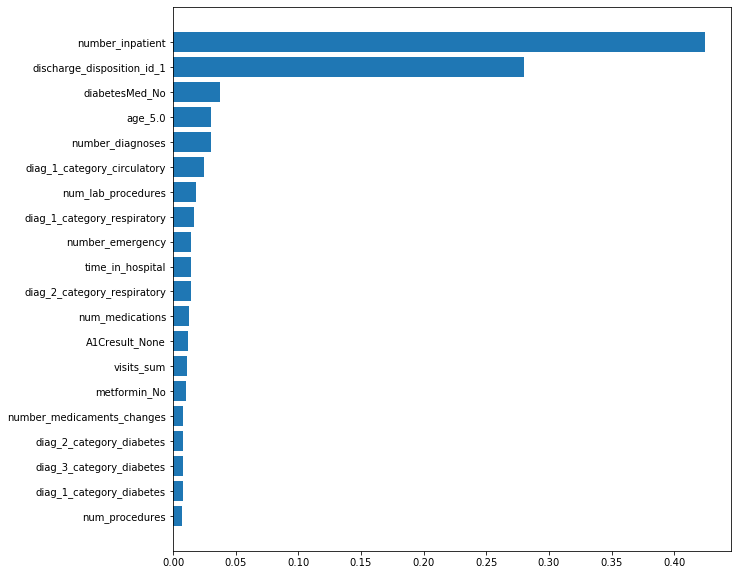

In [65]:
sorted_features = plot_feature_importance(xg.feature_importances_, X_train.columns, 20)

#### MLP (multilayer perceptron)

##### 1. Original data

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18090
           1       0.37      0.01      0.02      2263

    accuracy                           0.89     20353
   macro avg       0.63      0.50      0.48     20353
weighted avg       0.83      0.89      0.84     20353

ROC AUC score: 0.5


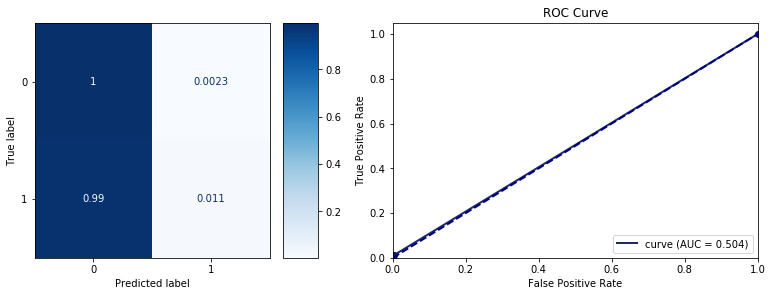

In [72]:
mlp = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=30, activation = 'relu',solver='adam')
mlp.fit(X_train, y_train)
evaluate_model(mlp, X_test, y_test)

##### 2. Undersampled data

              precision    recall  f1-score   support

           0       0.88      0.47      0.61     18090
           1       0.10      0.50      0.17      2263

    accuracy                           0.47     20353
   macro avg       0.49      0.48      0.39     20353
weighted avg       0.80      0.47      0.56     20353

ROC AUC score: 0.48


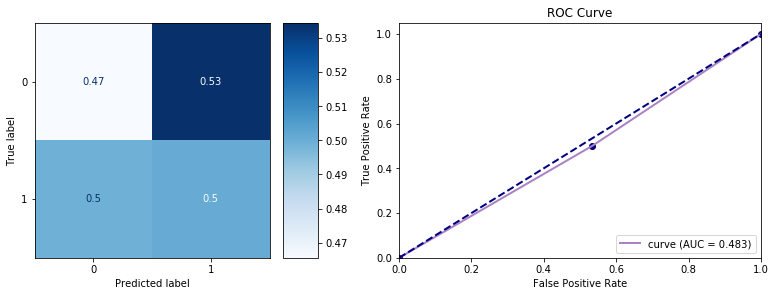

In [68]:
mlp_u = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=20,activation = 'relu',solver='adam',random_state=1)
mlp_u.fit(X_train_undersampled, y_train_undersampled)
evaluate_model(mlp_u, X_test, y_test)

##### 3. Oversampled data

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18090
           1       0.20      0.01      0.02      2263

    accuracy                           0.89     20353
   macro avg       0.55      0.50      0.48     20353
weighted avg       0.81      0.89      0.84     20353

ROC AUC score: 0.5


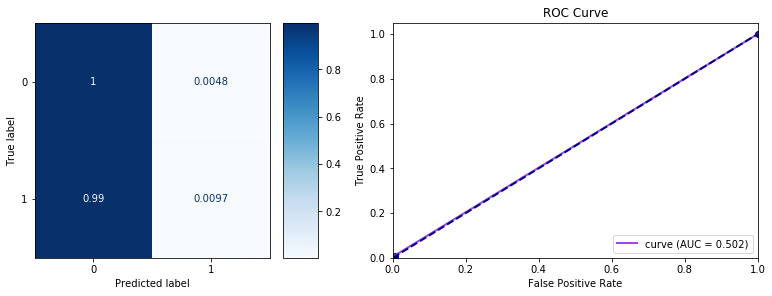

In [69]:
mlp_o = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=20,activation = 'relu',solver='adam',random_state=1)
mlp_o.fit(X_train_oversampled, y_train_oversampled)
evaluate_model(mlp_o, X_test, y_test)

##### MLP conclusion

We did not achieve better results with MLP, what may be caused by unbalanced train data and oversampling which needed also data balancing despite data should be balanced. But in undersampled data  we achieved best results.


In [71]:
compare_models([mlp, mlp_u, mlp_o], 
               ['MLP', 'MLP undersampled', 'MLP oversampled'], 
               X_test, y_test)

                     Accuracy   F1 (micro)  F1 (macro)  Precission   Recall   AUC ROC
MLP                |   0.89   |   0.89    |   0.48    |   0.52    |   0.01   |   0.50   |
MLP undersampled   |   0.47   |   0.47    |   0.39    |   0.10    |   0.50   |   0.48   |
MLP oversampled    |   0.89   |   0.89    |   0.48    |   0.20    |   0.01   |   0.50   |


### Finall comparision of models

Final comparision of all models you can see in the table bellow. The best score AUC achieved Random forest on original data. XGBoost has very similar results to Random forest and  MLP can not deal with unbalanced data. 

In our experiments, techniques to balance data as oversampling SMOTE and undersampling NearMiss did not help to better performance. It may by caused by examples randomly placed in feature speace, what means that we can not clearly divide classes by any machine learning model. This is one of the explanation for achieving only 0.61 AUC score.

In [74]:
compare_models([rf, rf_u, rf_o, xg, xg_u, xg_o, mlp, mlp_u, mlp_o], 
               ['RF', 'RF undersampled', 'RF oversampled',
                'XGBoost', 'XGBoost undersampled', 'XGBoost oversampled',
                'MLP', 'MLP undersampled', 'MLP oversampled'], 
               X_test, y_test)

                         Accuracy   F1 (micro)  F1 (macro)  Precission   Recall   AUC ROC
RF                     |   0.60   |   0.60    |   0.49    |   0.16    |   0.62   |   0.61   |
RF undersampled        |   0.37   |   0.37    |   0.33    |   0.10    |   0.56   |   0.46   |
RF oversampled         |   0.47   |   0.47    |   0.41    |   0.13    |   0.68   |   0.56   |
XGBoost                |   0.48   |   0.48    |   0.43    |   0.14    |   0.74   |   0.60   |
XGBoost undersampled   |   0.38   |   0.38    |   0.34    |   0.10    |   0.55   |   0.46   |
XGBoost oversampled    |   0.54   |   0.54    |   0.45    |   0.14    |   0.58   |   0.56   |
MLP                    |   0.89   |   0.89    |   0.48    |   0.37    |   0.01   |   0.50   |
MLP undersampled       |   0.47   |   0.47    |   0.39    |   0.10    |   0.50   |   0.48   |
MLP oversampled        |   0.89   |   0.89    |   0.48    |   0.20    |   0.01   |   0.50   |
